# Problem Statement <br>

The goal of this competition is to identify metastatic cancer in small image patches taken from larger digital pathology scans of lymph node sections. It is a binary image classification task, where each image patch is labeled as either containing metastatic tissue (label=1) or not (label=0).

## Data Description <br>
Images are 96x96 pixel RGB patches (TIF format).
There are 220,005 labeled training images and 57,000 test images.
Each image has a unique ID. Labels are provided in train_labels.csv (columns: id, label).


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import seaborn as sns
import pandas as pd
import tifffile
import tensorflow as tf
import matplotlib.pyplot    as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics       import roc_curve, auc, roc_auc_score
from PIL import Image


## Initial EDA below

In [3]:
# ────────────────────────────────────────────────
# 0) Settings
IMAGE_PATH = 'data/histopathologic-cancer-detection/train/'
CSV_PATH   = 'data/histopathologic-cancer-detection/train_labels.csv'
IMG_SIZE   = (96, 96)
BATCH_SIZE = 32
RANDOM_SEED = 42
# ────────────────────────────────────────────────

# 1) Load CSV, build lists of file‐paths & labels
df = pd.read_csv(CSV_PATH)
ids    = df['id'].values
labels = df['label'].values.astype('float32')
paths  = [os.path.join(IMAGE_PATH, f"{i}.tif") for i in ids]

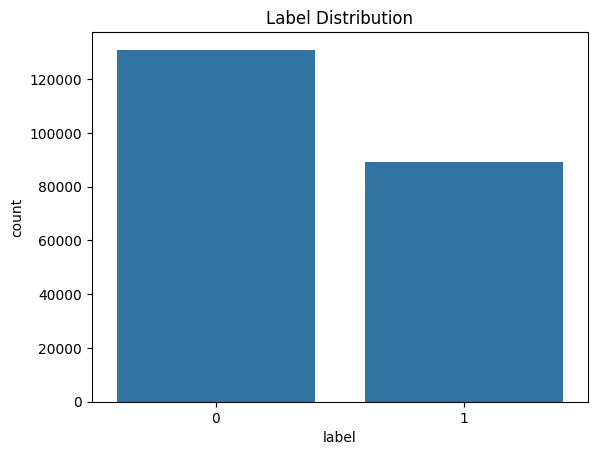

label
0    0.594969
1    0.405031
Name: proportion, dtype: float64


In [4]:
# Check class distribution
sns.countplot(x="label", data=df)
plt.title("Label Distribution")
plt.show()

print(df['label'].value_counts(normalize=True))

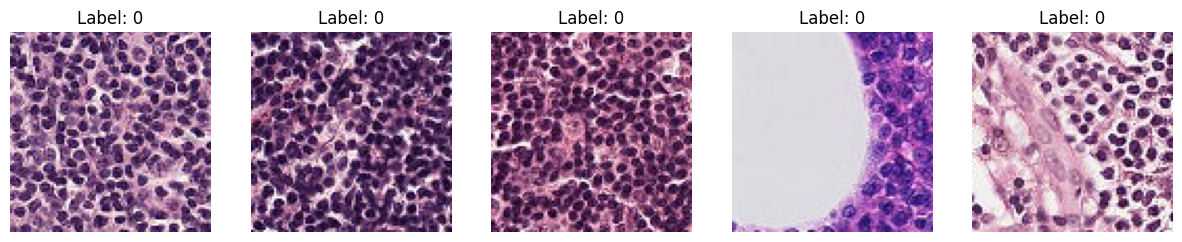

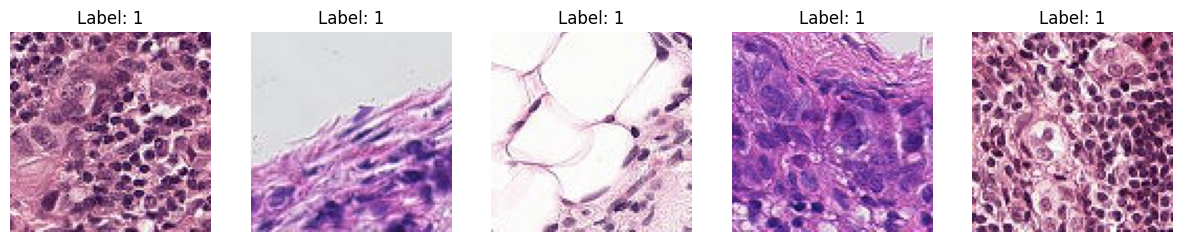

In [46]:
# Show random sample of images from each class
def plot_sample_images(df, img_dir, label, n=5):
    ids = df[df.label==label].sample(n, random_state=1)['id'].values
    plt.figure(figsize=(15,3))
    for i, img_id in enumerate(ids):
        img = Image.open(os.path.join(img_dir, img_id + ".tif"))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

plot_sample_images(df, IMAGE_PATH, label=0)
plot_sample_images(df, IMAGE_PATH, label=1)

## EDA Summary
The dataset is imbalanced: far more negative than positive samples.
<br>Images are small (96x96 RGB).
<br> It is not possible to look at cancer patch and see which has them has cancer. 

## Observations

The dataset is reasonably large for medical imaging (≈220k images).
Class imbalance is manageable but data‑augmentation of the minority class can help.

## Data Cleanliness

1. No missing values in labels.
2. No issues with missing images correspnding to ids

## Model Architecture

1. Initial analysis with simple Simple CNN (Conv2D layers + MaxPooling + Normalization + Dense).
2. Comparison: Pretrained model (Resnet via transfer learning).


### Why:
<br>
For image tasks, CNNs have proved to be the best option <br>
Transfer learning will help with accuracy<br>







In [5]:
# Train/test split (stratify to keep class balance)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    paths, labels,
    test_size=0.2,
    stratify=labels,
    random_state=RANDOM_SEED
)

In [6]:
# 3) A tiny tf.data loader
def load_tiff(path, label):
    def _read(p):
        # p is a bytes scalar
        img = tifffile.imread(p.numpy().decode('utf-8'))  # H×W×3 uint8
        return img.astype(np.float32) / 255.0              # normalize
    img = tf.py_function(_read, [path], tf.float32)
    img.set_shape(IMG_SIZE + (3,))
    return img, label

def make_dataset(paths, labels, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(len(paths), seed=RANDOM_SEED)
    ds = (ds
          .map(load_tiff,   num_parallel_calls=tf.data.AUTOTUNE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))
    return ds

In [7]:
train_ds = make_dataset(train_paths, train_labels, shuffle=True)
test_ds  = make_dataset(test_paths,  test_labels,  shuffle=False)

In [10]:
# Building a small CNN
model = tf.keras.Sequential([
    # 1) Stem
    tf.keras.layers.Input(shape=IMG_SIZE+(3,)),

    # 2) Conv blocks
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(),

    # 3) Normalize & pool
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),

    # 4) Compact dense head
    tf.keras.layers.Dense(32, activation='relu'), 
    tf.keras.layers.Dropout(0.3),                  

    # 5) Final sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 96, 96, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 48, 48, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 48, 48, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,761 (85.00 KB)

 Trainable params: 21,633 (84.50 KB)

 Non-trainable params: 128 (512.00 B)

In [11]:
#  Train 
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 469s 85ms/step - accuracy: 0.7954 - loss: 0.4558 - val_accuracy: 0.7197 - val_loss: 0.6634
Epoch 2/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 480s 87ms/step - accuracy: 0.8384 - loss: 0.3773 - val_accuracy: 0.8253 - val_loss: 0.3818
Epoch 3/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 495s 90ms/step - accuracy: 0.8578 - loss: 0.3390 - val_accuracy: 0.8319 - val_loss: 0.3962
Epoch 4/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 512s 93ms/step - accuracy: 0.8698 - loss: 0.3179 - val_accuracy: 0.7782 - val_loss: 0.4516
Epoch 5/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 512s 93ms/step - accuracy: 0.8786 - loss: 0.2986 - val_accuracy: 0.8474 - val_loss: 0.3569
Epoch 6/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 528s 96ms/step - accuracy: 0.8853 - loss: 0.2860 - val_accuracy: 0.8689 - val_loss: 0.3040
Epoch 7/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 528s 96ms/step - accuracy: 0.8884 - loss: 0.2783 - val_accuracy: 0.8749 - val_loss: 0.2998
Epoch 8/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 584s 100ms/step - accuracy:

In [12]:
model.save("model/cancer_detector_model_simplecnn.keras")

# Load the model
#model = tf.keras.models.load_model(model_path)

In [13]:
# Predict on test set
y_true = test_labels                        # shape (N_test,)
y_pred = model.predict(test_ds).ravel()     # shape (N_test,)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 92s 66ms/step


Test  ROC AUC = 0.9512


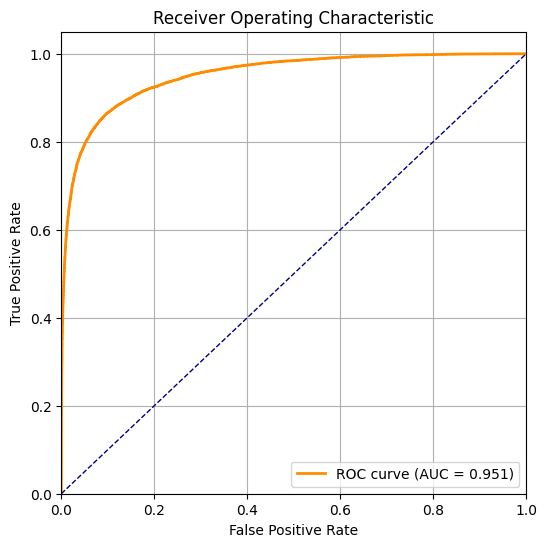

In [14]:
# 7) Compute ROC + AUC
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)
print(f"Test  ROC AUC = {roc_auc:.4f}")

# 8) Plot ROC curve
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

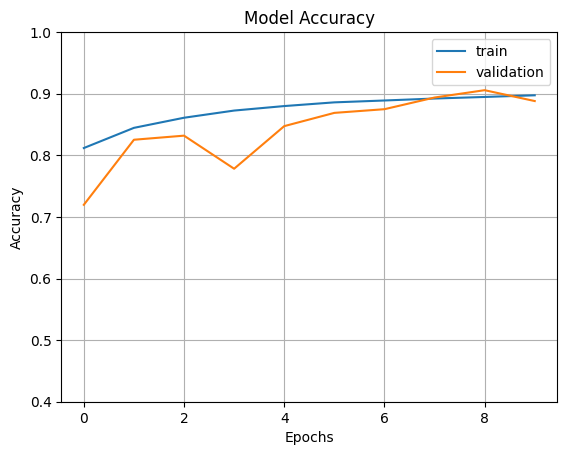

In [15]:

fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [39]:

def get_transfer_model(input_shape):
    # 1) Load backbone without its top
    base = tf.keras.applications.ResNet50(
        include_top=False,
        input_shape=input_shape,
        weights='imagenet'
    )
    base.trainable = False  # freeze all ImageNet weights
    # 2) Build new head
    transfer_model = tf.keras.Sequential([
        base,
        tf.keras.layers.GlobalAveragePooling2D(),  
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    # 3) Compile for binary classification
    transfer_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC', 'accuracy']
    )
    return transfer_model


transfer_model = get_transfer_model((96,96,3))

history2 = transfer_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

Epoch 1/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2207s 399ms/step - AUC: 0.7917 - accuracy: 0.7297 - loss: 0.5393 - val_AUC: 0.8386 - val_accuracy: 0.7672 - val_loss: 0.4882
Epoch 2/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2405s 437ms/step - AUC: 0.8208 - accuracy: 0.7512 - loss: 0.5100 - val_AUC: 0.8412 - val_accuracy: 0.7685 - val_loss: 0.4829
Epoch 3/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2478s 450ms/step - AUC: 0.8249 - accuracy: 0.7555 - loss: 0.5048 - val_AUC: 0.8439 - val_accuracy: 0.7725 - val_loss: 0.4798
Epoch 4/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2588s 470ms/step - AUC: 0.8250 - accuracy: 0.7564 - loss: 0.5055 - val_AUC: 0.8447 - val_accuracy: 0.7709 - val_loss: 0.4786
Epoch 5/5
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 2692s 489ms/step - AUC: 0.8291 - accuracy: 0.7598 - loss: 0.5003 - val_AUC: 0.8454 - val_accuracy: 0.7736 - val_loss: 0.4777


In [ ]:
history2 = transfer_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

In [34]:
model.save("model/cancer_detector_model_resnet.keras")

# Loading the model
#loaded_model = tf.keras.models.load_model(model_path)

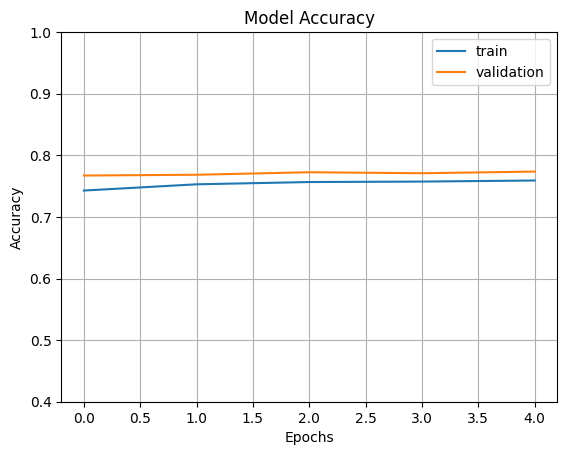

In [40]:
fig1 = plt.gcf()
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

## Results Summary
Simple CNN AUC
Resnet Transfer AUC
Transfer learning yielded higher AUC and was faster to converge. Data augmentation and class weights both helped.

## Conclusions & Learnings
At the conclusion of this exercise, Simple CNN was showing better accuracy. But, because of time constraints, Resnet was trained for only 5 epochs and clearly, the model is underfitting. 

## Limitations: 
Large dataset 

## Future improvements: 

1. Use streaming for improved performance. 
2. Fine-tune the base model, 
3. Experiment with other architectures and regularization 
4. More hyperparameter tuning.